# MDAnalysis and Pilot-In-Memory


The main performance bottleneck of the current MDAnalysis implementation is the construction of the graph using NetworkX taking ~78% of the overall runtime.


**Beckstein Profiling:**

    47        10           33      3.3      0.0      if adj is None:
    48        10        66544   6654.4      0.0          x = atoms.positions

    54        10     58689221 5868922.1     18.8          adj = (MDAnalysis.core.parallel.distances.distance_array(x, x, box=box) < cutoff)
    
    58        10           78      7.8      0.0      adjk = adj if Nmax is None else adj[:Nmax, :Nmax] 
    59        10    243009076 24300907.6   77.9      graph = nx.Graph(adjk)
    60        10      4346636 434663.6      1.4      subgraphs = nx.connected_components(graph)
    61        49        83597   1706.1      0.0      indices = [np.sort(g) for g in subgraphs]
    62        49      5694698 116218.3      1.8      return [atoms[group].residues for group in indices]



## 1. LeafletFinder NetworkX Implementation Profiling

see https://code.google.com/p/mdanalysis/

Profile default implementation based on [NetworkX](https://networkx.github.io/)

In [2]:
FILENAME="../data/mdanalysis/small/graph_edges_95_215.csv"
!head -n 5 {FILENAME}

0,0
0,67
0,14
1,1
1,41


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.2 µs


/home/01131/tg804093/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/01131/tg804093/anaconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


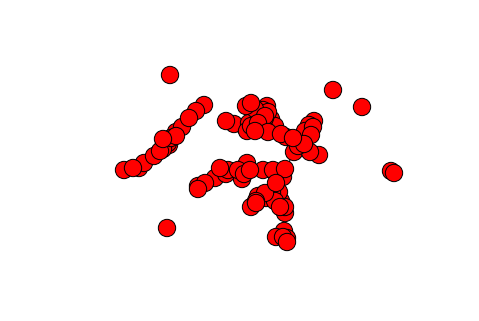

In [3]:
%matplotlib inline
%time
import networkx as NX
import time
import datetime
import sys

start = time.time()
nxg = NX.read_edgelist(FILENAME, delimiter=",")
end_read = time.time()
NX.draw(nxg, pos=NX.spring_layout(nxg))

Degree sequence [7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2]
Length: 95


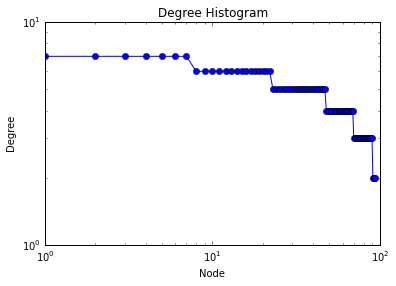

In [4]:
import matplotlib.pyplot as plt
degree_sequence=sorted(NX.degree(nxg).values(),reverse=True) # degree sequence
print "Degree sequence", degree_sequence
print "Length: %d" % len(degree_sequence)

dmax=max(degree_sequence)

plt.loglog(degree_sequence,'b-',marker='o')
plt.title("Degree Histogram")
plt.ylabel("Degree")
plt.xlabel("Node")

In [5]:
start = time.time()
components = NX.connected_components(nxg)
end_created = time.time()
count = 0
for component in components:
    print str(sorted(component))
    count = count + 1
end_connected = time.time()
print ("Number of Nodes: " + str(NX.number_of_nodes(nxg)))
print ("Number of Edges: " + str(NX.number_of_edges(nxg)))
print ("Connected Components: " + str(count))
print ("Runtime: " + str((end_connected-start)))
print ("Graph Creation Runtime: " + str((end_created-start)))
print ("Connected Components Runtime: " + str((end_connected - end_created)))

[u'0', u'13', u'14', u'2', u'24', u'25', u'26', u'29', u'34', u'37', u'48', u'49', u'5', u'52', u'57', u'6', u'61', u'62', u'64', u'65', u'67', u'70', u'79', u'86', u'89']
[u'1', u'12', u'19', u'22', u'23', u'27', u'3', u'30', u'33', u'38', u'39', u'4', u'41', u'44', u'50', u'51', u'54', u'59', u'66', u'68', u'7', u'72', u'87', u'9', u'91', u'94']
[u'11', u'17', u'20', u'28', u'42', u'46', u'55', u'58', u'60', u'69', u'73', u'75', u'8', u'81', u'85', u'88', u'90', u'93']
[u'21']
[u'56', u'76']
[u'32', u'35', u'36', u'43', u'45', u'47', u'53', u'63', u'74', u'77', u'78', u'80', u'82', u'84', u'92']
[u'83']
[u'10', u'16', u'31', u'40', u'71']
[u'15']
[u'18']
Number of Nodes: 95
Number of Edges: 215
Connected Components: 10
Runtime: 0.000586986541748
Graph Creation Runtime: 0.000107049942017
Connected Components Runtime: 0.000479936599731


In [6]:
import os
from pilot_hadoop import PilotComputeService
from IPython.display import HTML

os.environ["SAGA_VERBOSE"]="100"

KeyError: 'SPARK_HOME'

## 2. Pilot-Spark and Pilot-InMemory Implementation

Setup Spark cluster on local machine or HPC resource. Execute **either** 2.1.1 or 2.1.2

### 2.1.1 Start Spark Cluster using Pilot-Spark (Stampede)

see https://github.com/drelu/saga-hadoop

In [ ]:
pilot_compute_description = {
                            "resource_url":"fork://localhost",
                            "number_cores": 1,
                            "cores_per_node":1,
                            "type":"spark"
                            }
pilot = PilotComputeService.create_pilot(pilot_compute_description);

# print out details of Pilot-Spark
details = pilot.get_details()
HTML("<a target='blank' href='%s'>Spark Web UI</a>"%details["web_ui_url"])

In [7]:
pilot_compute_description = {
                            "resource_url":"spark://129.114.58.102:7077",
                            "type":"spark"
                            }
pilot = PilotComputeService.create_pilot(pilot_compute_description);

# print out details of Pilot-Spark
details = pilot.get_details()
HTML("<a target='blank' href='%s'>Spark Web UI</a>"%details["web_ui_url"])

NameError: name 'PilotComputeService' is not defined

### 2.1.2 Start Spark Cluster inside YARN (Chameleon)

In [1]:
%run util/init_spark.py

NUMBER_EXECUTORS=10

from pilot_hadoop import PilotComputeService as PilotSparkComputeService

pilotcompute_description = {
    "service_url": "yarn-client://yarn.radical-cybertools.org",
    "number_of_processes": NUMBER_EXECUTORS,
    "physical_memory_per_process": "16G" 
}

print "SPARK HOME: %s"%os.environ["SPARK_HOME"]
print "PYTHONPATH: %s"%os.environ["PYTHONPATH"]

start = time.time()
pilot_spark = PilotSparkComputeService.create_pilot(pilotcompute_description=pilotcompute_description)
sc = pilot_spark.get_spark_context()
print "Spark Startup, %.2f"%(time.time()-start)

SPARK Home: /usr/hdp/2.3.2.0-2950/spark-1.5.2-bin-hadoop2.6
SPARK HOME: /usr/hdp/2.3.2.0-2950/spark-1.5.2-bin-hadoop2.6
PYTHONPATH: /usr/hdp/2.3.2.0-2950/spark-1.5.2-bin-hadoop2.6/python:/usr/hdp/2.3.2.0-2950/spark-1.5.2-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip
Spark Startup, 11.35


## 2.1.3. Start Spark Cluster (Wrangler)

    export JAVA_HOME=/usr/java/jdk1.8.0_45/
    saga-hadoop --resource=slurm://localhost --queue=normal --walltime=59 --number_cores=24 --project=TG-MCB090174 --framework spark

In [2]:
%run util/init_spark_wrangler.py

from pilot_hadoop import PilotComputeService as PilotSparkComputeService

pilotcompute_description = {
    "service_url": "spark://129.114.58.102:7077"
}

print "SPARK HOME: %s"%os.environ["SPARK_HOME"]
print "PYTHONPATH: %s"%os.environ["PYTHONPATH"]

start = time.time()
pilot_spark = PilotSparkComputeService.create_pilot(pilotcompute_description=pilotcompute_description)
sc = pilot_spark.get_spark_context()
print "Spark Startup, %.2f"%(time.time()-start)

SPARK HOME: /usr/hdp/2.3.2.0-2950/spark-1.5.2-bin-hadoop2.6
PYTHONPATH: /usr/hdp/2.3.2.0-2950/spark-1.5.2-bin-hadoop2.6/python:/usr/hdp/2.3.2.0-2950/spark-1.5.2-bin-hadoop2.6/python/lib/py4j-0.8.2.1-src.zip


ValueError: Cannot run multiple SparkContexts at once; existing SparkContext(app=Pilot-Spark, master=yarn-client) created by __init__ at /opt/anaconda/lib/python2.7/site-packages/SAGA_Hadoop-_1-py2.7.egg/pilot_hadoop/__init__.py:282 

## 2.2 Spark Smoke Test

In [16]:
!hadoop fs -text "/data/mdanalysis/synthetic/10.np_txt"

1.301420623392496509e+03 2.807832551900155522e+02 2.517563129104106849e+02
2.722167575165602102e+03 4.524193726434879181e+02 1.592189925343543848e+02
5.842721832229260599e+02 5.011435847301913213e+02 5.019247754474058638e+02
2.676534474822494758e+02 2.893733369314094261e+02 2.954777836778528695e+02
1.565075348390562795e+03 3.608543095645551944e+02 1.134437320806232492e+02
1.658199319222987697e+03 3.291993573871811805e+02 7.002703797869543223e+01
1.311563278013026775e+03 3.981094962466687548e+02 6.506046180358148376e+02
1.608137592276664463e+03 5.706915520466751559e+02 4.280808877849850660e+02
6.934849080272874744e+02 4.326217518426430502e+02 1.355185659709867423e+02
9.707393720972518167e+02 3.646477485149743529e+02 2.577698715039838362e+02


In [18]:
sc.addFile("hdfs:///data/mdanalysis/synthetic/10.np_txt")

In [2]:
rdd=sc.parallelize(range(2))

In [ ]:
rdd.count()

In [ ]:
import os, subprocess
rdd.map(lambda a: subprocess.check_output('python --version', shell=True, stderr=subprocess.STDOUT)).collect()

## 2.3 Distance Computation

### 2.3.1 Use File Staging

In [39]:
from pyspark import SparkFiles
from MDAnalysis.core.distances import distance_array, self_distance_array
from MDAnalysis.analysis.distances import contact_matrix
import scipy.sparse
import numpy as np
from scipy.spatial.distance import cdist
import sys
import gc

cutoff = 15.0

def get_edges_partition(adjacency_matrix, cutoff=15.0):
    it = np.nditer(adjacency_matrix, flags=['multi_index'])
    edge_list = []
    while not it.finished:
        value = it[0]
        if cutoff < value:
            # only connect 1 undirectional edge, e.g. <0,1>, but not <1,0>'
            if it.multi_index[0]<=it.multi_index[1]:
                edge_list.append((it.multi_index[0], it.multi_index[1]))
                #print "%d <%s>" % (it[0], it.multi_index),
        it.iternext()
    return edge_list

def compute_distance_file(point_index_data_file):
    # 1-D Partitioning
    point_index_start = point_index_data_file[0]
    point_index_end = point_index_data_file[1]
    data = point_index_data_file[2]
    filename=SparkFiles.get(data)
    coord_all = np.loadtxt(filename, dtype='float32')
    coord_part = coord_all[point_index_start:point_index_end]
    adj = cdist(coord_part, coord_all)
    edge_list = get_edges_partition(adj)
    del adj
    #del coord_part
    #del coord_all
    #gc.collect()
    #return edge_list
    return edge_list

Read File Test

In [40]:
import math
#data=sc.textFile(DATA_FILE).collect()
import hdfs
import numpy as np
client = hdfs.client.Client("http://radical-5:50070")
DATA_FILE="hdfs:///data/mdanalysis/small/md_centered.xtc_95Atoms.np_txt"
PARTITION_SIZE=10
content=None
with client.read(DATA_FILE.replace("hdfs://", "")) as reader:
    content=reader.read()
data=np.fromstring(content, dtype="float32", sep=" \n")
data=data.reshape(len(data)/3,3)
number_rows=len(data)
number_partitions=(number_rows/PARTITION_SIZE)+1
print "Number Partitions: %d"%number_partitions

partitions=map(lambda a: (a*PARTITION_SIZE, 
                         (a*PARTITION_SIZE)+PARTITION_SIZE, 
                         os.path.basename(DATA_FILE)), 
           range(number_partitions))
partitions

Number Partitions: 10


[(0, 10, 'md_centered.xtc_95Atoms.np_txt'),
 (10, 20, 'md_centered.xtc_95Atoms.np_txt'),
 (20, 30, 'md_centered.xtc_95Atoms.np_txt'),
 (30, 40, 'md_centered.xtc_95Atoms.np_txt'),
 (40, 50, 'md_centered.xtc_95Atoms.np_txt'),
 (50, 60, 'md_centered.xtc_95Atoms.np_txt'),
 (60, 70, 'md_centered.xtc_95Atoms.np_txt'),
 (70, 80, 'md_centered.xtc_95Atoms.np_txt'),
 (80, 90, 'md_centered.xtc_95Atoms.np_txt'),
 (90, 100, 'md_centered.xtc_95Atoms.np_txt')]

In [41]:
len(partitions)

10

In [42]:
sc.addFile(DATA_FILE)
part_rdd=sc.parallelize(partitions, len(partitions))
start = time.time()
edges_list=part_rdd.map(compute_distance_file).flatMap(lambda a: a).collect()
print str(len(edges_list))
print "ComputeDistanceSpark, %d, %d, %.2f"%(len(data), NUMBER_EXECUTORS, (time.time()-start))

8359
ComputeDistanceSpark, 95, 10, 1.06


### HDFS Staging

In [22]:
import hdfs
import numpy as np
client = hdfs.client.Client("http://radical-5:50070")
content=client.read("/data/mdanalysis/small/md_centered.xtc_95Atoms.np_txt").read()
data_np=np.fromstring(content, dtype="float32", sep=" \n")
data_np=data_np.reshape(len(data_np)/3,3)
len(data_np)

In [32]:

data_np=np.fromstring(content, dtype="float32", sep=" \n")
data_np=data_np.reshape(len(data_np)/3,3)
len(data_np)

95

In [5]:
NUMBER_EXECUTORS

96

In [ ]:
partitions

In [ ]:
os.path.basename(DATA_FILE)

### 2.3.1 Broadcast-based Implementation (Optimized)

In [43]:
import numpy as np
#coord = np.loadtxt("vesicle_1_5M_373_stride1000.xtc_145746Atoms.np_txt", dtype='float32')
#coord = np.loadtxt("/data/mdanalysis/medium/md_prod_12x12_everymicroS_pbcmolcenter.xtc_44784Atoms.np_txt", dtype='float32')
coord = np.loadtxt("/data/mdanalysis/small/md_centered.xtc_95Atoms.np_txt", dtype='float32')

In [28]:
!hadoop fs -ls /data/mdanalysis/small

Found 6 items
-rw-r--r--   3 luckow hdfs       1241 2015-11-25 00:03 /data/mdanalysis/small/graph_edges_95_215.csv
drwxr-xr-x   - luckow hdfs          0 2015-11-25 00:03 /data/mdanalysis/small/graph_edges_95_215.parquet
-rw-r--r--   3 luckow hdfs       3772 2015-11-25 00:03 /data/mdanalysis/small/graph_edges_95_215_alledges.csv
-rw-r--r--   3 luckow hdfs       1241 2015-11-25 00:03 /data/mdanalysis/small/graph_edges_95_215_tab.csv
-rw-r--r--   3 luckow hdfs        275 2015-11-25 00:03 /data/mdanalysis/small/graph_nodes_95_215.csv
-rw-r--r--   3 luckow hdfs       7125 2015-12-06 15:51 /data/mdanalysis/small/md_centered.xtc_95Atoms.np_txt


In [44]:
coord_broadcast = sc.broadcast(coord)

In [45]:
coord_all = coord_broadcast.value

In [46]:
coord_all[1:5]

array([[ 46.68199921,  66.16099548,  63.26799774],
       [ 67.522995  ,  68.6230011 ,  54.61399841],
       [ 40.35400009,  14.70999908,  42.97800064],
       [ 42.58300018,  36.86699677,  11.01300049]], dtype=float32)

In [47]:
part_rdd=sc.parallelize(range(len(coord_broadcast.value)), NUMBER_EXECUTORS)
part_rdd.cache()

ParallelCollectionRDD[20] at parallelize at PythonRDD.scala:423

The following code wraps the MDAnalysis functions into Spark code that is executed in a data-parallel way either on an individual or a batch of points (1-D partitioning)

In [48]:
from MDAnalysis.core.distances import distance_array, self_distance_array
from MDAnalysis.analysis.distances import contact_matrix
import scipy.sparse
from scipy.spatial.distance import cdist
import sys
import gc


cutoff = 15.0

################################################################################
# Process batch of points (a partition of the RDD)

def get_edges_partition(adjacency_matrix, cutoff=15.0):
    it = np.nditer(adjacency_matrix, flags=['multi_index'])
    edge_list = []
    while not it.finished:
        value = it[0]
        if cutoff < value:
            # only connect 1 undirectional edge, e.g. <0,1>, but not <1,0>'
            if it.multi_index[0]<=it.multi_index[1]:
                edge_list.append((it.multi_index[0], it.multi_index[1]))
                #print "%d <%s>" % (it[0], it.multi_index),
        it.iternext()
    return edge_list

def compute_distance_partition(iterator):
    """Partition points in 1-D"""
    min_value=sys.maxint
    max_value=-sys.maxint-1
    for i in iterator:
        if i < min_value:
            min_value = i
        if i > max_value:
            max_value = i
    
    # 2-D Partitioning
    coord_all = coord_broadcast.value
    coord_part = coord_all[min_value:max_value]
    #print "**All**"
    #print str(coord_all)
    #print "**Part**"
    #print str(coord_part)
    #adj=contact_matrix(coord_part, returntype="sparse")
    #adj = distance_array(coord_part, coord_all, box=None)
    adj = cdist(coord_part, coord_all)
    #print "**scipy.spatial.distance.cdist**"
    #print(adj)
    #adj2 = distance_array(coord_part, coord_all, box=None)
    #print "**MDAnalysis**"
    #print(adj2)
    
    edge_list = get_edges_partition(adj)
    del coord_part
    del coord_all
    del adj
    gc.collect()
    return edge_list


################################################################################
# Process one point at a time
def get_edges_point(point_index, adjacency_matrix, cutoff=15.0):
    edge_list = []
    for index, i in np.ndenumerate(adjacency_matrix):
        #print ("Index: %d, Value: %d"%(index[i], i))
        #if point_index<=index[1] and i<cutoff:
        if i==True and point_index<=index[1]:
            # Attention we only compute the upper half of the adjacency matrix
            # thus we need to offset the target edge vertice by point_index
            edge_list.append((point_index, point_index+index[1]))
    #del adjacency_matrix
    return edge_list

def compute_distance(point_index):
    # 1-D Partitioning
    coord_all = coord_broadcast.value
    coord_part = coord_all[point_index-1:point_index]
    #adj = (distance_array(coord_part, coord_all[point_index:], box=None) < cutoff)
    adj = (cdist(coord_part, coord_all) < cutoff)
    #adj = cdist(coord_part, coord_all)
    edge_list = get_edges_point(point_index, adj)
    del adj
    #del coord_part
    #del coord_all
    #gc.collect()
    return edge_list

In [50]:
start = time.time()
#edges_list=part_rdd.map(compute_distance).flatMap(lambda a: a).collect()
edges_list_spark=part_rdd.mapPartitions(compute_distance_partition).collect()
print str(len(edges_list))
print "ComputeDistanceSpark, %d, %d, %.2f"%(len(coord_all), NUMBER_EXECUTORS, (time.time()-start))

83
ComputeDistanceSpark, 95, 10, 2.20


In [8]:
#start = time.time()
#edges_list_local = compute_distance_partition(iter(range(20000)))
#print str(len(edges_list))
#print "ComputeDistanceLocal, %d, %.2f"%(len(coord_all),(time.time()-start))

for i in range(1):
    start = time.time()
    edges_list=part_rdd.map(compute_distance).flatMap(lambda a: a).collect()
    #edges_list_spark=part_rdd.mapPartitions(compute_distance_partition).collect()
    print str(len(edges_list))
    print "ComputeDistanceSpark, %d, %d, %.2f"%(len(coord_all), NUMBER_EXECUTORS, (time.time()-start))
    del edges_list

115093
ComputeDistanceSpark, 20000, 96, 114.90


## Unoptimized using cartesian product

Not good for sparse result data. Only usable on a very small sample:

    sample=row_rdd.sample(False, 0.01, 81)
    sample.count()


In [3]:
import pyspark.mllib.linalg.distributed
coord_matrix=pyspark.mllib.linalg.distributed.RowMatrix(sc.parallelize(coord[:200], 4))
row_rdd=coord_matrix.rows
row_rdd.cache()

MapPartitionsRDD[3] at mapPartitions at PythonMLLibAPI.scala:1480

In [4]:
row_rdd.count()

200

In [14]:
coord = np.loadtxt("md_centered.xtc_95Atoms.np_txt", dtype='float32')
#coord_str = np.array2string(coord, separator=",")

In [17]:
coord

array([[ 36.83100128,  20.13500023,  37.15499878],
       [ 46.68199921,  66.16099548,  63.26799774],
       [ 67.522995  ,  68.6230011 ,  54.61399841],
       [ 40.35400009,  14.70999908,  42.97800064],
       [ 42.58300018,  36.86699677,  11.01300049],
       [ 22.73099899,  54.88199615,  39.13800049],
       [ 69.51100159,  34.54999924,  27.00699997],
       [ 49.21099854,  27.49599838,  60.3809967 ],
       [ 49.60199738,  20.21199989,   6.79399967],
       [ 30.53499985,   4.55800009,   7.03599977],
       [  9.27799988,   8.9829998 ,  38.02500153],
       [  8.0369997 ,  66.09799957,  39.86299896],
       [ 55.26000214,   4.08699989,  67.3999939 ],
       [ 30.85899734,  59.57500076,  10.19099998],
       [ 26.04100037,  13.67999935,  44.57299805],
       [ 51.84799576,  22.13299942,  33.64899826],
       [  7.06699944,  25.31699944,  59.99300003],
       [ 23.29599762,  33.74100113,  74.61499786],
       [ 64.36899567,  68.68099976,  30.96899986],
       [ 18.94499969,  39.68700

In [20]:
coord.shape[0]

95

In [32]:
coord_str=[]
for i in range(len(coord)):
    coord_str.append(str(coord[i][0]) +","+ str(coord[i][1]) +","+ str(coord[i][2]))

In [3]:
start = time.time()
sc.parallelize(range(200), 4).count()
print "Count, %.2f"%((time.time()-start))

Count, 26.45


In [5]:
row_rdd.cartesian(row_rdd).map(lambda a: a).collect()

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job cancelled because SparkContext was shut down
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:703)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$cleanUpAfterSchedulerStop$1.apply(DAGScheduler.scala:702)
	at scala.collection.mutable.HashSet.foreach(HashSet.scala:79)
	at org.apache.spark.scheduler.DAGScheduler.cleanUpAfterSchedulerStop(DAGScheduler.scala:702)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onStop(DAGScheduler.scala:1514)
	at org.apache.spark.util.EventLoop.stop(EventLoop.scala:84)
	at org.apache.spark.scheduler.DAGScheduler.stop(DAGScheduler.scala:1438)
	at org.apache.spark.SparkContext$$anonfun$stop$7.apply$mcV$sp(SparkContext.scala:1724)
	at org.apache.spark.util.Utils$.tryLogNonFatalError(Utils.scala:1185)
	at org.apache.spark.SparkContext.stop(SparkContext.scala:1723)
	at org.apache.spark.scheduler.cluster.YarnClientSchedulerBackend$MonitorThread.run(YarnClientSchedulerBackend.scala:146)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:567)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1824)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1837)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1850)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1921)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:909)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:147)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:108)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:310)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:908)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:405)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:231)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:379)
	at py4j.Gateway.invoke(Gateway.java:259)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:133)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:207)
	at java.lang.Thread.run(Thread.java:745)


In [ ]:
start = time.time()
distances=  row_rdd.cartesian(row_rdd).\
            map(lambda a: (a[0].squared_distance(a[1]))).\
            filter(lambda a: a>15.0).\
            saveAsTextFile("distances.csv")
print "ComputeDistance, %.2f"%(time.time()-start)

## n-D Partitioning

In [ ]:
num_partitions=4

def compute_distance_2d(partition_index):
    # 2-D Partitioning
    coord_all = coord_broadcast.value[:100]
    length = len(coord_all)
    # identify square to work on    
    xdim = math.sqrt(num_partitions)
    ydim = math.sqrt(num_partitions)
    xdim/partition_index
    len=len(coord_all)
    

## 2.4 Leaflet Finder Pilot-InMemory Implementation (Graph)

In [ ]:
from distributed_inmem.dataunit_spark import DistributedInMemoryDataUnit
import time

FILENAME="../data/mdanalysis/small/graph_edges_95_215.csv"

FILENAME_ALL_EDGES="../data/mdanalysis/small/graph_edges_95_215_alledges.csv"
du = DistributedInMemoryDataUnit(name="LeafletFinderGraph", sc=sc)

#DistributedInMemoryDataUnit.spark_context.version

f = open(FILENAME_ALL_EDGES)
graph = f.readlines()
du.load(graph)
f.close()

def identityMapper(edge, args):
    #print edge
    #comp = edge.strip().split(",")
    #return (int(comp[0]), int(comp[1]))
    return eval(str(edge))

def groupByVertex(data):
    print("Call reduce on: " + str(data))
    

new_iteration_needed = du.sc.accumulator(0)

# check for smaller keys in each set
def process_vertex(vertex):
    """ pass single vertex and its adjecent vertices
        e.g.: (0, [0, 67, 14])
    """
    global new_iteration_needed
    vertex = eval(vertex)
    source = int(vertex[0])
    dest= sorted([int(i) for i in vertex[1]])
    local_max = False
    
    first_edge_destination = int(dest[0])
    new_vertices = []    
    print "*********Source: %d First Edge Dest: %d"%(source, first_edge_destination) 
    if source <= first_edge_destination:
        local_max = True
        new_vertices.append((source, first_edge_destination))
            

    print "Process: " + str(vertex) + " Local Max: " + str(local_max)
    last_edge_destination = first_edge_destination

    for current_destination in vertex[1]:
        print "Current destination: %s"%str(current_destination)
        current_destination = int(current_destination)
        if current_destination == last_edge_destination: 
            continue
        
        if local_max == True:
            edge = (source, current_destination)
            new_vertices.append(edge)
        else:
            new_vertices.append((first_edge_destination, current_destination))
            new_vertices.append((current_destination, first_edge_destination))
            print "Add 1 to accumulator"
            new_iteration_needed.add(1)

        last_edge_destination = current_destination
    
    if ((not local_max) and (source < last_edge_destination)):
        new_vertices.append((source, first_edge_destination))
    
    print "Return new vertices: " + str(new_vertices)
    return new_vertices


#process_vertex("('19', ['19', '7', '9', '41'])")
num_iterations=0
start = time.time()
while True:
    old_accum_value = new_iteration_needed.value
    print "*********** Start iteration: %d " % num_iterations
    future_result = du.map_pilot(identityMapper, None, number_of_compute_units=2)
    result_du=future_result.result()[0]
    future_result = result_du.reduce_pilot(process_vertex, number_of_compute_units=2)
    output = future_result.result()
    output.export()   
    du = output
    num_iterations = num_iterations + 1
    print "New iteration accum: %d old value: %d"%(new_iteration_needed.value, old_accum_value)
    if old_accum_value < new_iteration_needed.value:
        #print "Accumulator value was increased. New iteration."
        continue        
        #pass
    else:
        break
    break
end = time.time()
print "Final results: "
num_components=du.data.groupByKey().count()
print "Finished after %d Iterations. Found %d components. Time: %.2f"%(num_iterations, num_components, (end-start)) 


In [ ]:
du.data.groupByKey().count()

## 2.5 Native Spark Implementation

In [3]:
!hadoop fs -ls /data/mdanalysis/large

Found 1 items
-rw-r--r--   3 luckow hdfs   29855041 2015-11-25 00:03 /data/mdanalysis/large/graph_edges_145746_1012872.csv


In [ ]:
rdd = sc.textFile("/data/mdanalysis/large/graph_edges_145746_1012872.csv")

### 2.5.1 Load data from text file 

In [8]:
%%time
FILENAME="/data/mdanalysis/small/graph_edges_95_215.csv"
data = sc.textFile(FILENAME).map(lambda line: [int(i) for i in line.split(",")])
# add backward edges
data = data.flatMap(lambda v: [(v[0],v[1]),(v[1],v[0])])

#data.saveAsTextFile("../data/mdanalysis/small/graph_edges_95_215_alledges.csv")
#data = data.filter(lambda v: v[0] != v[1])
#print data.collect()

data_grouped = data.groupByKey().mapValues(lambda a: sorted(set(a)))
print data_grouped.collect()

[(0, [0, 14, 67]), (2, [2, 13, 34, 62]), (4, [4, 27, 33, 68, 94]), (6, [6, 57, 64, 67]), (8, [8, 46, 69, 88, 93]), (10, [10, 31, 40, 71]), (12, [7, 12, 30, 50, 91]), (14, [0, 14, 48, 64]), (16, [16, 40]), (18, [18]), (20, [20, 85]), (22, [22, 54]), (24, [24, 62]), (26, [26, 49, 57, 70]), (28, [11, 17, 28, 69]), (30, [9, 12, 23, 30, 50]), (32, [32, 53]), (34, [2, 34]), (36, [36, 47, 84, 92]), (38, [9, 23, 38]), (40, [10, 16, 31, 40, 71]), (42, [42, 73]), (44, [44, 68]), (46, [8, 46]), (48, [14, 48, 49]), (50, [12, 23, 30, 50]), (52, [29, 52, 79, 89]), (54, [22, 54, 87]), (56, [56, 76]), (58, [58, 81]), (60, [17, 60, 69, 81]), (62, [2, 24, 25, 62, 79, 89]), (64, [6, 14, 57, 64, 67]), (66, [51, 66]), (68, [4, 44, 68, 72, 94]), (70, [26, 70, 79, 86]), (72, [68, 72]), (74, [43, 47, 53, 74, 82]), (76, [56, 76]), (78, [78, 92]), (80, [43, 80]), (82, [74, 77, 82]), (84, [36, 63, 84]), (86, [70, 79, 86]), (88, [8, 69, 88, 93]), (90, [11, 55, 75, 90]), (92, [36, 47, 78, 92]), (94, [3, 4, 33, 59,

#### 2.3.2 Connected Component Implementation

In [9]:
new_iteration_needed = sc.accumulator(0)
# check for smaller keys in each set
def process_vertex(vertex):
    """ pass single vertex and its adjecent vertices
        e.g.: (0, [0, 67, 14])
    """
    global new_iteration_needed
    source = vertex[0]
    local_max = False
    
    first_edge_destination = vertex[1][0]
    new_vertices = []    
    print "*********Source: %d First Edge Dest: %d"%(source, first_edge_destination) 
    if source <= first_edge_destination:
        local_max = True
        new_vertices.append((source, first_edge_destination))
            
    #pdb.set_trace()
    print "Process: " + str(vertex) + " Local Max: " + str(local_max)
    last_edge_destination = first_edge_destination

    #if vertex[1]==None or len(vertex[1])<=1:
    #    new_vertices.append((source, source))   
    for current_destination in vertex[1]:
        # print "Current destination: %s"%str(current_destination)
        # remove duplicates
        if current_destination == last_edge_destination: 
            continue
        
        if local_max == True:
            edge = (source, current_destination)
            new_vertices.append(edge)
        else:
            new_vertices.append((first_edge_destination, current_destination))
            new_vertices.append((current_destination, first_edge_destination))
            print "Add 1 to accumulator"
            new_iteration_needed.add(1)

        last_edge_destination = current_destination
    
    if ((not local_max) and (source < last_edge_destination)):
        new_vertices.append((source, first_edge_destination))
    
    #print "Return new vertices: " + str(new_vertices)
    return new_vertices


#process_vertex((19, [7, 9, 19, 41]))
num_iterations=0
cc = data_grouped
start = time.time()
while True:
    old_accum_value = new_iteration_needed.value
    print "*********** Start iteration: %d " % num_iterations
    #print "Accum before iteration: " + str(old_accum_value)
    cc = cc.flatMap(lambda v: process_vertex(v))\
           .groupByKey()\
           .mapValues(lambda a: sorted(set(a)))
    cc.collect()
    num_iterations = num_iterations + 1
    #print "New iteration accum: %d old value: %d"%(new_iteration_needed.value, old_accum_value)
    if old_accum_value < new_iteration_needed.value:
        #print "Accumulator value was increased. New iteration."
        continue
    else:
        break
end = time.time()

print "Finished after %d Iterations. Found %d components. Time: %.2f"%(num_iterations, cc.count(), (end-start))

*********** Start iteration: 0 
*********** Start iteration: 1 
*********** Start iteration: 2 
*********** Start iteration: 3 
*********** Start iteration: 4 
*********** Start iteration: 5 
Finished after 6 Iterations. Found 10 components. Time: 2.39


## 3. Benchmark

---
## 4. Scratch Space

In [ ]:
#start = df_grouped
result=start.flatMap(lambda v: (v[0], v[1])).map(lambda v: v<start_index).countByValue()

print sttrresult

local_max = not result.has_key(True)

print "Local Max: " + str(local_max) + " Smaller Index: " + str(result.has_key(True))

In [ ]:
schema = StructType([
            StructField("source", IntegerType(), True),
            StructField("destination", IntegerType(), True)
        ])
df = sqlCtx.createDataFrame(data, schema)
df.explain()
schema_grouped = StructType([
            StructField("source", IntegerType(), True),
            StructField("destination", ArrayType(IntegerType()), True)
        ])
df_grouped = sqlCtx.createDataFrame(data_grouped, schema_grouped)

In [ ]:
from pyspark.sql.functions import udf, lit
from pyspark.sql.functions import *
from pyspark.sql.types import ArrayType

t = udf(lambda s: str(s), StringType())
slen = udf(lambda s: Column(len(s)), IntegerType())

#df.groupBy("source").collect()
#df.groupBy("source").agg(df.source, t(df.source))

c = df.groupBy(df.source).agg(col("source"), slen(df.destination))

#c = df.agg(col("source"), t(df.destination).alias('counts'))
c.head(5)


#c = df.groupBy(df.source).lit(df.destination)


In [ ]:
vertices = df.select(df["source"]).unionAll(df.select(df["destination"]))
vertices = di_source.distinct()

print "Number of vertices: %d"%(vertices.count())

# GraphLab

In [ ]:
from graphlab import SGraph, SFrame
from graphlab import connected_components

PROBLEM={"small": "./data/mdanalysis/small/graph_edges_95_215.csv",
         "medium":"./data/mdanalysis/medium/graph_edges_24056_71826.csv"}

d =datetime.datetime.now()
RESULTSFILE = "results-" + d.strftime("%Y%m%d-%H%M%S") + ".csv"
REPEATS=5

start = time.time()
data = SFrame.read_csv(filename, header=False)
sg = SGraph().add_edges(data, src_field="X1", dst_field="X2")
end_read=time.time()
cc = connected_components.create(sg)
s=cc["component_size"]
end_connected = time.time()
print cc
print s